## Wrapper for SUBSCALE Algorithm

In [1]:
import json
import os
import plotly.graph_objects as go
import datetime
import numpy as np
import pandas as pd
import plotly.express as px
import sys
import subprocess

new_working_dir = r'./SUBSCALE_C++'
config_path = r'config.json'
exe_path = r'./SubscaleGPU.exe'
config = None

def change_dir(new_working_dir):
    if os.path.basename(os.path.normpath(os.getcwd())) not in new_working_dir:
        os.chdir(new_working_dir)

def load_json(config, config_path):
    abs_config_path = os.path.abspath(config_path)
    with open(abs_config_path) as json_file:
        config = json.load(json_file)
    return config

def update_json(config, config_path):
    abs_config_path = os.path.abspath(config_path)
    with open(abs_config_path, "w") as json_file:
        json.dump(config, json_file)

def ms_to_human_readable(ms):
    totalSecond, mils = divmod(ms, 1000)
    totalMinute, second = divmod(totalSecond, 60)
    hour, minute = divmod(totalMinute, 60)
    return hour, minute, second, mils

def start_SUBSCLAE(config, exe_path, config_path):
    abs_data_dirname = os.path.dirname(os.path.abspath(config['dataPath']))
    if not os.path.exists(abs_data_dirname) or not os.path.isfile(os.path.abspath(config['dataPath'])):
        os.makedirs(abs_data_dirname)
        print("missing file in data-folder: \'{file}\'".format(file=os.path.abspath(config['dataPath'])))
    else:
        abs_result_dirname = os.path.abspath(config['resultPath'])
        if not os.path.exists(abs_result_dirname):
            os.makedirs(abs_result_dirname)

        print("Processing: Wait until SUBSCALE finishes and window is closed...")
        if sys.platform.startswith('win'): # for windows
            cmd = 'start {} {}'.format(os.path.abspath(exe_path), os.path.abspath(config_path))
        else:# for everything else,  with optimistic assumption that we are on linux
            cmd = 'xdg-open {} {}'.format(os.path.abspath(exe_path), os.path.abspath(config_path))
        #os.popen(cmd).read()
        cmd = ['start', os.path.abspath(exe_path), os.path.abspath(config_path)]
        p = subprocess.Popen(cmd, shell=True)


def help_config(name):
    if name is minPoints:
        print("number of points in a cluster")
    elif name is epsilon:
        print("distance to other points")
    elif name is splittingFactor:
        print("number of slices")
    elif name is dataPath:
        print("path to the input or data directory")
    elif name is resultPath:
        print("path to output or result directory")
    elif name is saveCandidates:
        print("[dim]-[DU] candidates in one single file")
    elif name is saveCandidatesMultiFiles:
        print("[dim]-[DU] candidates in files grouped by the amount of dimensions")
    elif name is useDBSCAN:
        print("Finds maximum clusters. Requires: saveCandidates")
    elif name is useDBSCAN_MultiFiles:
        print("Finds maximum clusters. Requires: saveCandidatesMultiFiles")
    elif name is saveClusters:
        print("Saves output from DBSCAN to one single file")
    elif name is saveClustersMultiFiles:
        print("Saves output from DBSCAN in files grouped by the amount of dimensions")
    elif name is runSequential:
        print("Runs either on CPU singlecored or on gpu with massive parallization")
    elif name is denseUnitTableSize:
        print("Size of table for [signatures]-DU")
    elif name is subspaceTableSize:
        print("Size of the table for the calculation of the slices")
    elif name is finalTableSize:
        print("Size of the table for the merged slices")
    elif name is threadsPerBlock:
        print("Number of CUDA Threads for each block")
    elif name is denseUnitsPerThread:
        print("Number of calculated DUs per kernel")

## Change working directory and load config file

In [2]:
change_dir(new_working_dir)
config = load_json(config, config_path)
print(json.dumps(config, indent=2))
print("curent data folder: "+ os.path.dirname(os.path.abspath(config['dataPath'])))
print("curent result folder: "+ os.path.abspath(config["resultPath"]))

{
  "minPoints": 4,
  "epsilon": 0.03,
  "splittingFactor": 3,
  "dataPath": "./../data/4_madelon_train_100.csv",
  "resultPath": "./../results/",
  "saveCandidates": true,
  "saveCandidatesMultiFiles": true,
  "useDBSCAN": false,
  "useDBSCAN_MultiFiles": false,
  "saveClusters": false,
  "saveClustersMultiFiles": false,
  "runSequential": false,
  "denseUnitTableSize": 800000,
  "subspaceTableSize": 500000,
  "finalTableSize": 3000000,
  "threadsPerBlock": 64,
  "denseUnitsPerThread": 3
}
curent data folder: C:\Users\ataru\Desktop\hso\thesis\SUBSCALE\daten\eigene\python\jup_lab\data
curent result folder: C:\Users\ataru\Desktop\hso\thesis\SUBSCALE\daten\eigene\python\jup_lab\results


### apply changes to config file

In [3]:
config['dataPath'] = "./../data/4_madelon_train_100.csv"
config['saveCandidatesMultiFiles'] = True
config['useDBSCAN'] = False
config['useDBSCAN_MultiFiles'] = False
config['saveClustersMultiFiles'] = False
config['minPoints'] = 4
config['epsilon'] = 0.03
config['splittingFactor'] = 20
# ... put your changes here
update_json(config, config_path)

## Start algorithm

In [4]:
start_SUBSCLAE(config, exe_path, config_path)

Processing: Wait until SUBSCALE finishes and window is closed...


# Results

In [ ]:
def info_slices(resultPath):
    time_Subscale = os.path.join(os.path.abspath(resultPath), "time_Subscale.txt")
    text_time_Subscale = None
    with open(time_Subscale) as fp:
        text_time_Subscale = fp.read()
    print(text_time_Subscale)
    
info_slices(config['resultPath'])

In [ ]:
def info_clusters(resultPath):
    time_Complete = os.path.join(os.path.abspath(resultPath), "time_Complete.txt")
    text_time_complete = None
    with open(time_Complete) as fp:
        text_time_complete = fp.read()
    print(text_time_complete)

info_clusters(config['resultPath'])

### Diplay DUs in Slices:

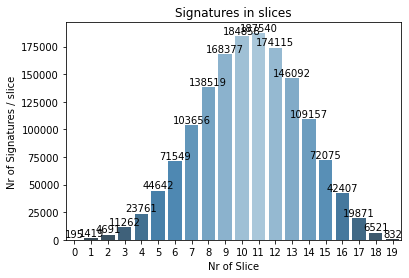

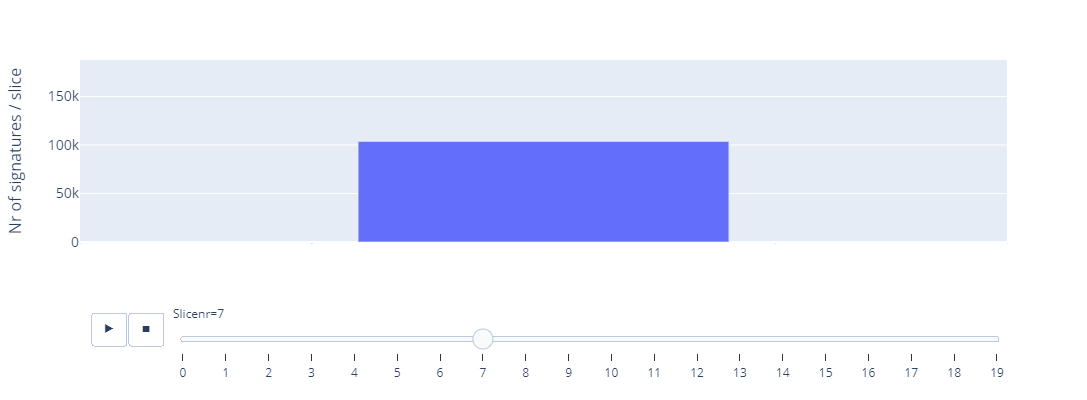

In [45]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def display_entries_per_slice(resultPath):
    cEpS = os.path.join(os.path.abspath(resultPath), "entriesPerSlice.txt")
    slices = np.loadtxt(cEpS, dtype=int)

    amount = pd.Series(slices, name="Nr of Signatures / slice")
    nr = pd.Series([x for x in range(len(slices))], name="Nr of Slice")

    pal = sns.color_palette("Blues_d", len(amount))
    rank = amount.argsort().argsort() 
    splot=sns.barplot(x=nr, y=amount, palette=np.array(pal[::-1])[rank])

    plt.title('Signatures in slices')
    for i in range(len(amount)):
        splot.text(nr[i], amount[i], amount[i], color='black', ha="center", va = 'bottom')

    plt.show()
    
    df_signatures = pd.DataFrame({'Slicenr':nr, 'Signatures':slices})
    fig = px.bar(df_signatures, 
                    x=[1 for x in range(len(slices))], y='Signatures', 
                    animation_frame="Slicenr",
                    log_x=False, range_x=[0,2], range_y=[0,max(slices)],
                    height=400, width=500).update_traces(textposition="outside")
    fig.update_layout(legend_title_text="Operations",
                        yaxis=dict(
                                            title='Nr of signatures / slice',
                                            titlefont_size=16,
                                            tickfont_size=14,),
                         xaxis=dict(
                                            title='',
                                            titlefont_size=16,
                                            tickfont_size=1,))
    fig.show()

display_entries_per_slice(config['resultPath'])

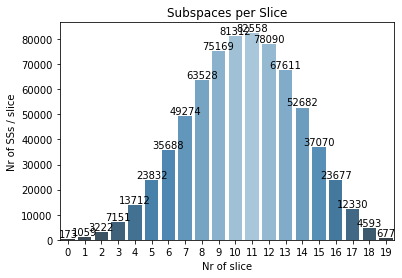

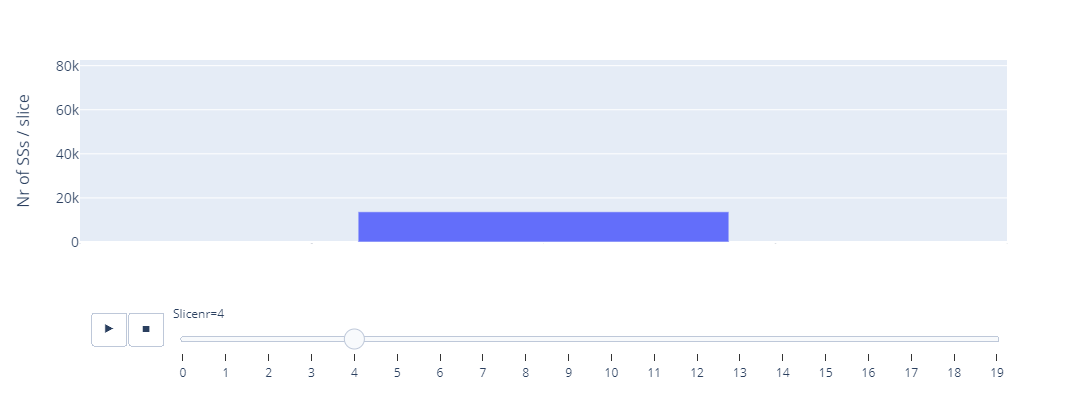

In [46]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, HTML

def display_entries_per_slice(resultPath):
    cEpS = os.path.join(os.path.abspath(resultPath), "condensedEntriesPerSlice.txt")
    slices = np.loadtxt(cEpS, dtype=int)

    amount = pd.Series(slices, name="Nr of SSs / slice")
    nr = pd.Series([x for x in range(len(slices))], name="Nr of slice")

    pal = sns.color_palette("Blues_d", len(amount))
    rank = amount.argsort().argsort() 
    splot=sns.barplot(x=nr, y=amount, palette=np.array(pal[::-1])[rank])

    plt.title('Subspaces per Slice')
    for i in range(len(amount)):
        splot.text(nr[i], amount[i], amount[i], color='black', ha="center", va = 'bottom')

    plt.show()
    
    df_subspaces = pd.DataFrame({'Slicenr':nr, 'Subspaces':slices})
    fig = px.bar(df_subspaces, 
                    x=[1 for x in range(len(slices))], y='Subspaces', 
                    animation_frame="Slicenr",
                    log_x=False, range_x=[0,2], range_y=[0,max(slices)],
                    height=400, width=500).update_traces(textposition="outside")
    fig.update_layout(legend_title_text="Operations",
                        yaxis=dict(
                                            title='Nr of SSs / slice',
                                            titlefont_size=16,
                                            tickfont_size=14,),
                         xaxis=dict(
                                            title='',
                                            titlefont_size=16,
                                            tickfont_size=1,))
    fig.show()

display_entries_per_slice(config['resultPath'])

### Times for joining and loading the slices

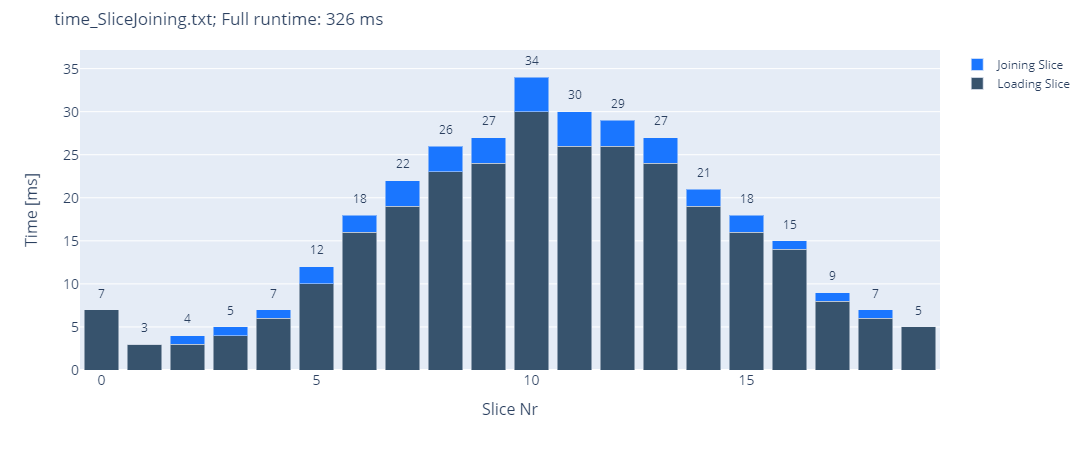

slice selection


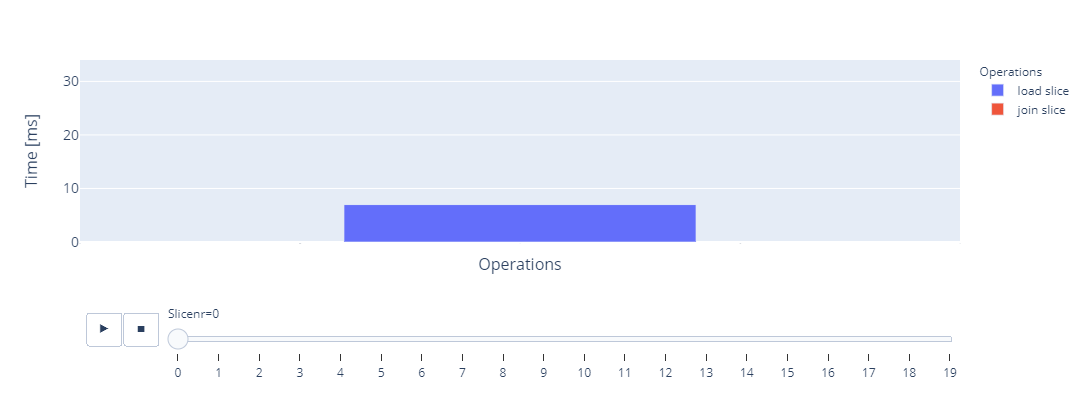

In [38]:
import plotly.graph_objects as go

def display_time_per_slice(resultPath):
    time_SliceJoining = os.path.join(os.path.abspath(resultPath), "time_SliceJoining.txt")

    line_counter = 0
    join_slice = list()
    load_slice = list()
    full_runtime = None
    with open(time_SliceJoining) as fp:
        for line in fp:        
            if 'slice' in line:
                numbers = [int(s) for s in line.split() if s.isdigit()]
                if len(numbers) > 0:
                    line_counter += 1
                    if line_counter % 2 == 1:
                        load_slice.append(numbers[0] if numbers else None)
                    else:
                        join_slice.append(numbers[0] if numbers else None)
            elif 'Full runtime' in line:
                full_runtime = line

    slices = [x for x in range(len(load_slice))]
    total_time = [load_slice[i]+join_slice[i] for i in range(len(load_slice))]
    fig = go.Figure(data=[
        go.Bar(name='Loading Slice', x=slices , y=load_slice, marker_color='rgb(55, 83, 109)'),
        go.Bar(name='Joining Slice', x=slices, y=join_slice, marker_color='rgb(26, 118, 255)')
    ])
    max_total_time = max(total_time)
    total_labels = [{"x": x, "y": total+max_total_time/(max_total_time/2), "text": str(total), "showarrow": False} for x, total in zip(slices, total_time)]
    fig = fig.update_layout(annotations=total_labels)
    # Change the diagram  attributes
    plot_title = "time_SliceJoining.txt; " + full_runtime
    fig.update_layout(barmode='stack', title=plot_title,
                      yaxis=dict(
                                    title='Time [ms]',
                                    titlefont_size=16,
                                    tickfont_size=14
                                    
                      ),
                      xaxis=dict(
                                    title='Slice Nr',
                                    titlefont_size=16,
                                    tickfont_size=14,), 
                     margin=dict(
                                 t = 50)
                     )
    fig.show()
    
    print("slice selection")
    op_names = ['load slice', 'join slice']
    df_slices = pd.DataFrame({'load slice':load_slice, 'join slice':join_slice, 'Slicenr':slices})
    max_val = 0

    l_summed = list()
    for i in range(len(load_slice)):
        summed = sum(df_slices.iloc[i,:-1].values.tolist())
        l_summed.append(summed)
        if summed > max_val:
            max_val = summed

    fig = px.bar(df_slices, 
                    x=[1 for x in range(len(load_slice))], y=op_names, 
                    animation_frame="Slicenr",
                    log_x=False, range_x=[0,2], range_y=[0,max_val],
                    height=400, width=500).update_traces(textposition="outside")
    
    fig.update_layout(legend_title_text="Operations",
                        yaxis=dict(
                                            title='Time [ms]',
                                            titlefont_size=16,
                                            tickfont_size=14,),
                         xaxis=dict(
                                            title='Operations',
                                            titlefont_size=16,
                                            tickfont_size=1,))
    
    fig.show()

display_time_per_slice(config['resultPath'])

stacked


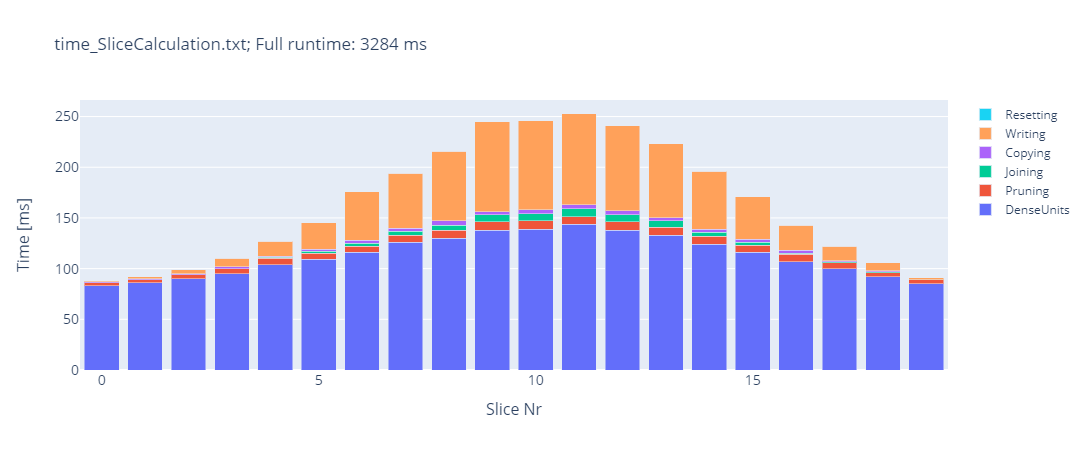

grouped:


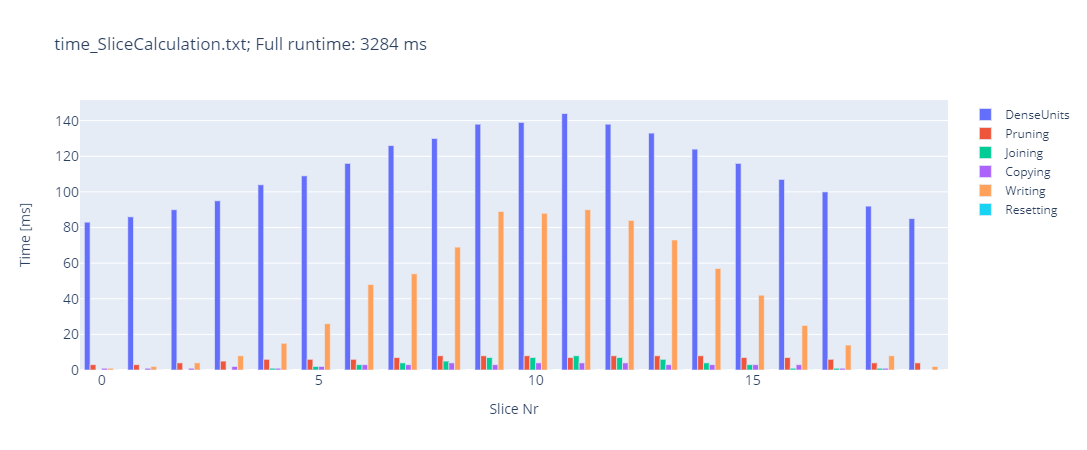

summed per category:


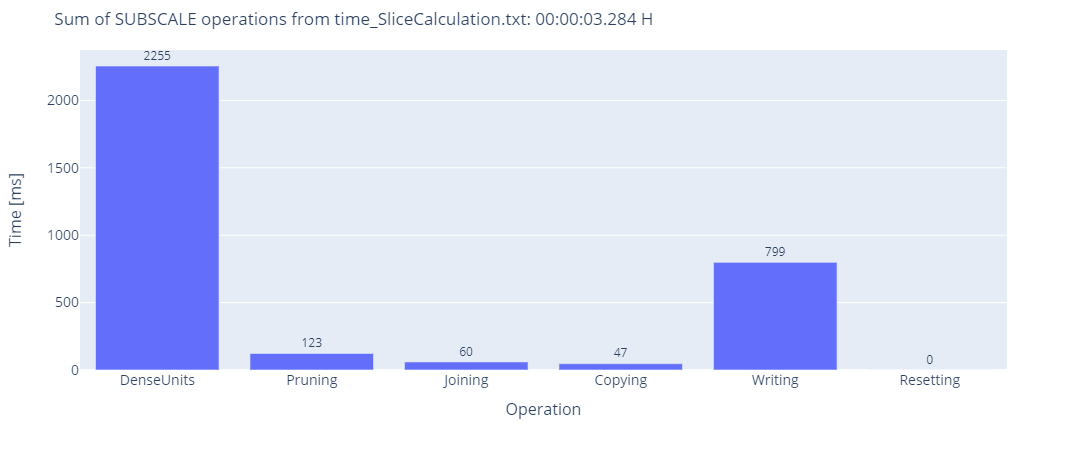

Display only one slice at a time:


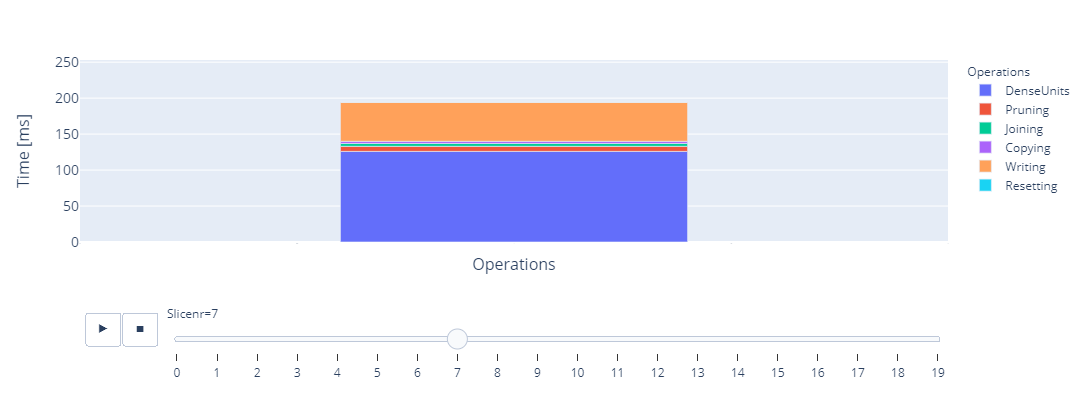

In [30]:
import plotly.graph_objects as go
import datetime

def display_time_slice_calculation(resultPath):
    time_SliceJoining = os.path.join(os.path.abspath(resultPath), "time_SliceCalculation.txt")

    line_counter = 0
    l_Slicenr = list()
    l_DenseUnits = list()
    l_Pruning = list()
    l_Joining = list()
    l_Copying = list()
    l_Writing = list()
    l_Resetting = list()
    df = [l_DenseUnits, l_Pruning, l_Joining, l_Copying, l_Writing, l_Resetting, l_Slicenr]
    names = ["DenseUnits", "Pruning", "Joining", "Copying", "Writing", "Resetting", "Slicenr"]

    full_runtime = None
    with open(time_SliceJoining) as fp:
        for line in fp: 
            if 'Full runtime' in line:
                full_runtime = line
            elif 'ms' in line and 'Full execution time' not in line:
                for s in line.split():
                    if '.' in s and line_counter % 6 == 0:
                        l_Slicenr.append(int(s.strip('.')))
                        #print(s+'; '+ str(line_counter % 6) + '; ' + str(line_counter) +'; ' + line)
                    if s.isdigit():
                        df[line_counter % 6].append(int(s))
                line_counter += 1

    time_slices = list()
    for i in range(len(names)-1):
        time_slices.append(go.Bar(name = names[i], x = l_Slicenr, y = df[i]))

    fig = go.Figure(data = time_slices)

    # Change the diagram  attributes
    plot_title = "time_SliceCalculation.txt; " + full_runtime
    print("stacked")
    fig.update_layout(barmode='stack',
                      title=plot_title, 
                          yaxis=dict(
                                        title='Time [ms]',
                                        titlefont_size=16,
                                        tickfont_size=14,),
                          xaxis=dict(
                                        title='Slice Nr',
                                        titlefont_size=16,
                                        tickfont_size=14,))
    fig.show()

    print("grouped:")
    fig.update_layout(barmode='group',
                      title=plot_title, 
                          yaxis=dict(
                                        title='Time [ms]',
                                        titlefont_size=16,
                                        tickfont_size=14,),
                          xaxis=dict(
                                        title='Slice Nr',
                                        titlefont_size=16,
                                        tickfont_size=14,))
    fig.show()
    
    print("summed per category:")
    l_categories = list()
    for cat in range(len(df)-1):
        l_categories.append(sum(df[cat]))
    
    # total time in ms
    total_time_ms = int(sum(l_categories))
    # convert to readable form
    str_time = "{:02d}:{:02d}:{:02d}.{:03d}".format(*ms_to_human_readable(total_time_ms))
    plot_title = "Sum of SUBSCALE operations from {}: {} H".format(plot_title.split(';')[0], str_time)
    fig = go.Figure([go.Bar(x = names, y = l_categories, text=l_categories, textposition='outside')])                
    fig.update_layout(barmode='stack', title=plot_title, margin=dict(t = 50),
                          yaxis=dict(
                                        title='Time [ms]',
                                        titlefont_size=16,
                                        tickfont_size=14,),
                     xaxis=dict(
                                        title='Operation',
                                        titlefont_size=16,
                                        tickfont_size=14,))
    fig.show()
    
    print("Display only one slice at a time:")
    df_all = pd.DataFrame()
    max_val = 0
    for i in range(len(names)):
        df_all[names[i]] = df[i]

    df_sorted=df_all.sort_values('Slicenr', ascending = True)

    l_summed = list()
    for i in range(len(df[0])):
        summed = sum(df_sorted.iloc[i,:-1].values.tolist())
        l_summed.append(summed)
        if summed > max_val:
            max_val = summed

    fig = px.bar(df_sorted, 
                    x=[1 for x in range(len(df[0]))], y=names[:-1], 
                    animation_frame="Slicenr",
                    log_x=False, range_x=[0,2], range_y=[0,max_val],
                    height=400, width=500).update_traces(textposition="outside")
    fig.update_layout(legend_title_text="Operations",
                        yaxis=dict(
                                            title='Time [ms]',
                                            titlefont_size=16,
                                            tickfont_size=14,),
                         xaxis=dict(
                                            title='Operations',
                                            titlefont_size=16,
                                            tickfont_size=1,))
    
    fig.show()


display_time_slice_calculation(config['resultPath'])

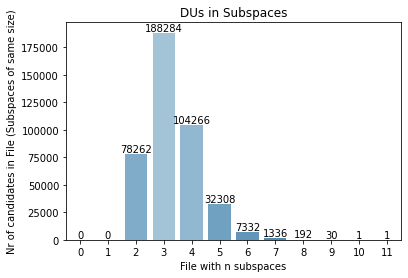

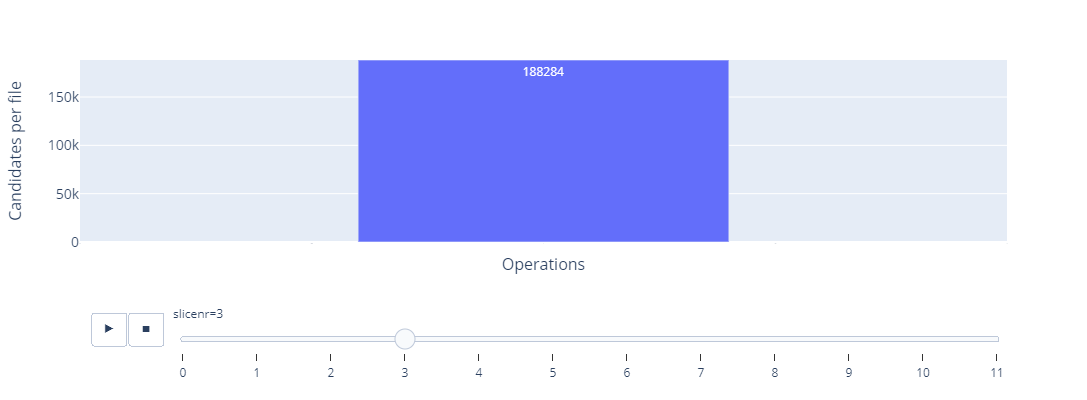

In [47]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def display_entries_per_subspace_file(resultPath):
    path_to_file = os.path.join(os.path.abspath(resultPath), "candidates/SubspaceClusterFilesSizes.txt")
    slices = np.loadtxt(path_to_file, dtype=int)
    
    amount = pd.Series(slices, name="Nr of candidates in File (Subspaces of same size)")
    nr = pd.Series([x for x in range(len(slices))], name="File with n subspaces")

    pal = sns.color_palette("Blues_d", len(amount))
    rank = amount.argsort().argsort()
    splot=sns.barplot(x=nr, y=amount, palette=np.array(pal[::-1])[rank])

    plt.title('DUs in Subspaces')
    for i in range(len(amount)):
        splot.text(nr[i], amount[i], amount[i], color='black', ha="center", va = 'bottom')

    plt.show()
    
    
    df_candidates = pd.DataFrame({'slicenr':nr, 'candidates':slices})
    fig = px.bar(df_candidates,
                    x=[1 for x in range(len(nr))], y='candidates', 
                    animation_frame='slicenr', text='candidates',
                    log_x=False, range_x=[0,2], range_y=[0,max(slices)],
                    height=400, width=500).update_traces(textposition="outside")
    
    fig.update_layout(legend_title_text="Operations",
                        yaxis=dict(
                                            title='Candidates per file',
                                            titlefont_size=16,
                                            tickfont_size=14,),
                         xaxis=dict(
                                            title='Operations',
                                            titlefont_size=16,
                                            tickfont_size=1,))
    
    fig.show()
    
display_entries_per_subspace_file(config['resultPath'])

In [62]:
import itertools

def list_slice(dic, stop, start=0):
    if start == 0:
        return list(itertools.islice(dic.items(), stop))
    else:
        return list(itertools.islice(dic.items(), start, stop))

def load_csv_data(size, result_path, name, is_one_file=False):
    """
    Get file content as Python dictionary, with dimensions as key and point ids as value 
    :param size: size of subspace
    :param result_path: path of csv files
    :param is_one_file: if only one csv file for complete output was used
    :return: dict{(dim_1, dim_2, ..., dim_i):[id(P_1), id(P_2), ..., id(P_k)], ...}, i=size, k = minPoints
    """
    subspace_entries = dict()
    if is_one_file:
        path_to_file = os.path.join(os.path.abspath(result_path), "{}.csv".format(name))
    else:
        path_to_file = os.path.join(os.path.abspath(result_path), name, "{}.csv".format(size))
    if os.path.exists(path_to_file):
        with open(path_to_file) as fp:
            for line in fp:
                line = line.strip('\n')
                key, val = line.split('-')
                key = key.strip('[]')
                val = val.strip('[]')
                key = tuple(int(x) for x in key.split(','))
                if not is_one_file: # = Multiple files. We are alread in the desired file
                    val = [int(x) for x in val.split(',')]
                    subspace_entries[key]=val
                else: # if everything is in one file, then take only entries of desired size
                    if len(key) == size:
                        val = [int(x) for x in val.split(',')]
                        subspace_entries[key]=val
                    
    else:
        print("file not found:")
        print(path_to_file)

    return subspace_entries


In [64]:
subspace_7 = load_csv_data(7, config['resultPath'], "candidates")
subspace_7
n_items = list_slice(subspace_7, 5)
n_items

[((84, 90, 123, 228, 404, 458, 492), [18, 32, 41, 46]),
 ((68, 90, 212, 276, 332, 402, 423), [4, 8, 41, 44]),
 ((90, 107, 188, 205, 282, 325, 392), [1, 17, 61, 86]),
 ((85, 90, 234, 396, 402, 404, 423), [13, 52, 55, 72]),
 ((67, 90, 159, 182, 251, 273, 387), [12, 40, 60, 79])]

In [88]:
n_dim_clusters = load_csv_data(7, config['resultPath'], "clusters")
n_items = list_slice(n_dim_clusters, 5)
n_items

[((158, 166, 276, 350, 402, 404, 423), [77, 83, 89, 95]),
 ((39, 90, 198, 200, 205, 256, 404), [11, 34, 40, 62]),
 ((166, 228, 280, 350, 402, 423, 450), [30, 45]),
 ((7, 90, 159, 173, 280, 368, 423), [8, 32, 52, 70]),
 ((90, 166, 168, 236, 276, 332, 423), [8, 44, 70, 88])]

In [297]:
import numpy as np

def load_point(subspace, point_id, filepath):
    point = np.loadtxt(filepath, skiprows=point_id, delimiter=',', usecols=subspace, max_rows=1, dtype=float)
    return point

def get_existent_points_dict(d_clusters):
    d_points = dict()
    l = [x for x in d_clusters.values()]
    for i in range(len(l)):
        for p_id in l[i]:
            if p_id not in d_points:
                d_points[p_id] = [i]
            else:
                d_points[p_id].append(i)
    return d_points

def get_points_from_subspace(d_clusters, filepath):
    """
    Gets Pythpn dictionary of subspace-points records 
    :returns: subspace-points dictionary
    """
    d_results = dict()
    for subspace, points in d_clusters.items():
        d_results[subspace] = list()
        for point_id in points:
            loaded_p = load_point(subspace, point_id, filepath)
            d_results[subspace].append(loaded_p)
    return d_results

def get_points_from_subspace2(d_clusters, filepath):
    """
     Gets pandas DataFram of subspace-PointIDs-points records 
    :returns: DataFram
    """
    df_results = pd.DataFrame(columns=['subspace', 'Pointid', 'Point'])
    for subspace, points in d_clusters.items():
        df_results[subspace] = list()
        for i in range(len(points)):
            loaded_p = load_point(subspace, points[i], filepath)
            dictionary_row = {"subspace":subspace,"Pointid":points[i], "Point":loaded_p}
            df_results.append(dictionary_row, ignore_index=True)
    return df_results

